In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")
import random
random.seed(1)
import numpy as np
np.random.seed(1)

In [2]:
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint

## Developing an agent for SCML2021 (OneShot)

In 2021, we introduced a new track called SCML-OneShot which implements a simplified problem in which the agent can focus on the many to many concurrent negotiation problem without needing to worry about long term planning or production planning as is the case with the standard and collusion tracks. 

An overview of the one-shot game is available [here](http://www.yasserm.com/scml/overview_oneshot.pdf) and a full description for the details-savy person is available [here](http://www.yasserm.com/scml/scml2021oneshot.pdf). We suggest that you read (or skim) these documents before continuing.

Let's see the simplest possible agent (a do-nothing agent) but first, we will define a function to try our agents:

In [3]:
from collections import defaultdict
import random
from negmas import ResponseType
from scml.oneshot import *
from scml.scml2020 import is_system_agent

def try_agent(agent_type, n_processes=2):
    return try_agents([RandomOneShotAgent, agent_type], n_processes)

def try_agents(agent_types, n_processes=2, n_trials=1, draw=True):
    type_scores = defaultdict(float)
    counts = defaultdict(int)
    agent_scores = dict()
    for _ in range(n_trials):
        p = n_processes if isinstance(n_processes, int) else random.randint(*n_processes)
        world = SCML2020OneShotWorld(
        **SCML2020OneShotWorld.generate(agent_types, n_steps=10, n_processes=p), 
        construct_graphs=True,
        )
        world.run()

        all_scores = world.scores()
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            key = aid if n_trials == 1 else f"{aid}@{world.id[:4]}"
            agent_scores[key] = (
                 agent.type_name.split(':')[-1].split('.')[-1],           
                 all_scores[aid], 
                 '(bankrupt)' if world.is_bankrupt[aid] else ''
                )
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            type_ = agent.type_name.split(':')[-1].split('.')[-1]
            type_scores[type_] += all_scores[aid]
            counts[type_] += 1
    type_scores = {k: v/counts[k] if counts[k] else v for k, v in type_scores.items()}
    if draw:
        world.draw(what=["contracts-concluded"], 
                       steps=(0, world.n_steps), together=True, ncols=1, figsize=(20, 20))
        plt.show()
    
    return world, agent_scores, type_scores

def analyze_contracts(world):
    import pandas as pd
    data = pd.DataFrame.from_records(world.saved_contracts)
    return data.groupby(["seller_name", "buyer_name"])[["quantity", "unit_price"]].mean().transpose()


def print_agent_scores(agent_scores):
    for aid, (type_, score, bankrupt) in agent_scores.items():
        print(f"Agent {aid} of type {type_} has a final score of {score} {bankrupt}")
        
def print_type_scores(type_scores):
    print(sorted(tuple(type_scores.items()), key=lambda x: -x[1]))

Now we are ready to develop a do-nothing agent:

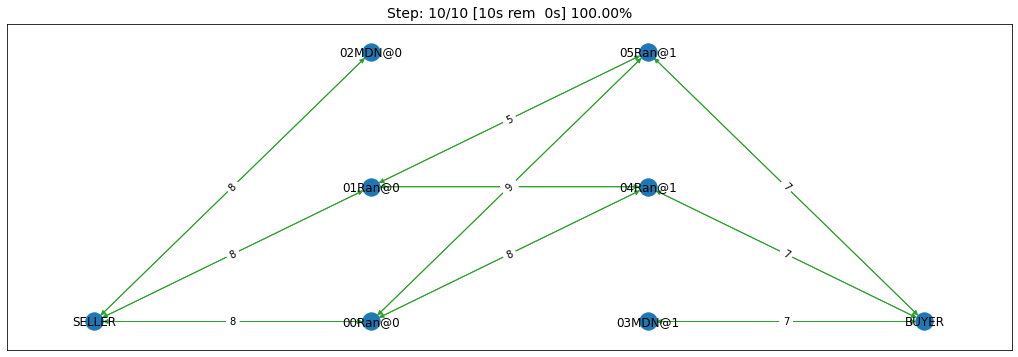

In [4]:
class MyOneShotDoNothing(OneShotAgent):
    """My Agent that does nothing"""
    def propose(self, negotiator_id, state):
        return None
    def respond(self, negotiator_id, state, offer):
        return ResponseType.END_NEGOTIATION
    
world, ascores, tscores = try_agent(MyOneShotDoNothing)

In all of the graph representing world simulations, we use short names that represent the type of the agent. For example an agent named `03Ran@1` is an agent of type `RandomOneShotAgent` at production level 1 that was the third agent to create. `MDN` here is a shorthand for `MyOneShotDoNothingAgent` (we will usually remove `OneShot` and `Agent` from the name before shortening it).

Looking at the `contracts-concluded`, we can see that none of the concluded contracts involved our do-nothing agent. Nevertheless, these agents still had *exogenous contracts* which means that they will lose money. A do-nothing agent will usually lose money in this game.

Let's check the scores of different agents to confirm:

In [5]:
print_agent_scores(ascores)

Agent 00Ran@0 of type RandomOneShotAgent has a final score of 0.8712623099937896 
Agent 01Ran@0 of type RandomOneShotAgent has a final score of 0.7859179150626892 
Agent 02MDN@0 of type MyOneShotDoNothing has a final score of 0.5367991250346996 
Agent 03MDN@1 of type MyOneShotDoNothing has a final score of 0.9284925068480194 
Agent 04Ran@1 of type RandomOneShotAgent has a final score of 0.5647184936971161 
Agent 05Ran@1 of type RandomOneShotAgent has a final score of 0.6361881881455568 


Notice that our do-nothing agent always loses money. That is because it cannot get any contracts from negotiation to satisfy its needs from the exogenous contracts but it still has to pay for storage cost and delivery penalty.

In [6]:
print_type_scores(tscores)

[('MyOneShotDoNothing', 0.7326458159413596), ('RandomOneShotAgent', 0.7145217267247879)]


Notice how the do-nothing agent is even worse than acting randomly. This is usually the case in the OneShot game.

We can also have a look at the *exogenous* contracts that drive the market.

In [7]:
analyze_contracts(world)

seller_name    00Ran@0            01Ran@0            03MDN@1 04Ran@1 05Ran@1  \
buyer_name     04Ran@1 05Ran@1    04Ran@1    05Ran@1   BUYER   BUYER   BUYER   
quantity      6.222222     5.0   6.555556   4.833333  10.625  13.625    6.75   
unit_price   25.222222    17.5  18.555556  21.000000  20.375  21.750   23.50   

seller_name  SELLER                  
buyer_name  00Ran@0 01Ran@0 02MDN@0  
quantity     10.375     9.0  10.625  
unit_price    9.750    10.5  10.125

There are few things to note about the distribution of the *exogenous* contracts:

- The unit price of the raw material is always lower than that of the final product. This is the source of profitability in this market.
- Each agent has a different mean and standar deviation for the quantities in its exogenous contracts. This means that different agents will have different utility functions but these utility functions for different steps are related because the exogenous contract is sampled from some common distribution for each agent for all the steps which makes learning more useful in the game.

### Building your own agent


A one-shot agent needs only to do negotiation. The simplest possible version (`MyOneShotRandom` above) just responded to offers from its partners and proposed new offers to them. 

Looking at the graph for the world simulation, we can see immediately some features of the one-shot simulation that are not replicated in the full SCML game:

- All negotiation requests are accepted. In fact in the one-shot game, the agent need not consider requesting negotiations or deciding the negotiation agenda as the system takes care of this ensuring that on every simulated day every agent is negotiating with its suppliers and or consumers about trade on that day (and only that day).
- Contracts in the one-shot game are always executed (despite not showing that in the graph). There is no concept of a breach. Failure to honor contracts is instead penalized monetarily. Contracts are also never cancelled or nullified. This greatly simplifies the problem as the agent does not need to keep track of contract execution.
- Production is too fast that it does not affect the agent reasoning. In the terminology to be presented in the following tutorial, there is no need for an explicit production strategy.
- There is no need to consider future negotiations while reasoning about a the current set of negotiations. This greatly simplifies agent design as there is no long-term planning. In the terminology to be presented in the following section, there is no need for a trading strategy


There are three base classes for one-shot agents (`OneShotAgent`, `SyncOneShotAgent`, and `SingleAgreementOneShotAgent`). We will discuss them in more details in what follows:

### OneShotAgent

This is the base class of all agents for SCML-OneShot. Both `SyncOneShotAgent` and `SingleAgreementOneShotAgent` inherit from this class and provide support for a simplified way of developing your agent (or so we think). It is perfectly OK to use `OneShotAgent` directly as the base of your agent.

We have already seen the `OneShotAgent` class for which you need to override `propose` and may also override `respond` to handle negotiations independently. The `propose` method receives the negotiation state (an object of the type `SAOState` including among other things the current negotiation step, relative time, last offer, etc) and is required to return an `Outcome` (See `negmas` documentation) as an offer. The `respond` method receives a negotiation state and an offer (`Outcome`) from the opponent and needs to respond to it by a decision from the `ResponseType` enumeration (`REJECT_OFFER`, `ACCEPT_OFFER`, and `END_NEGOTIATION`). Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `step` call after each step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these six callbacks. All of these callbacks except `propose` are optional.

#### Greedy OneShotAgent
We have already seen how to develop a do-nothing agent using the `OneShotAgent` class. Let's try to develop some more meaningful agent using the same base class.


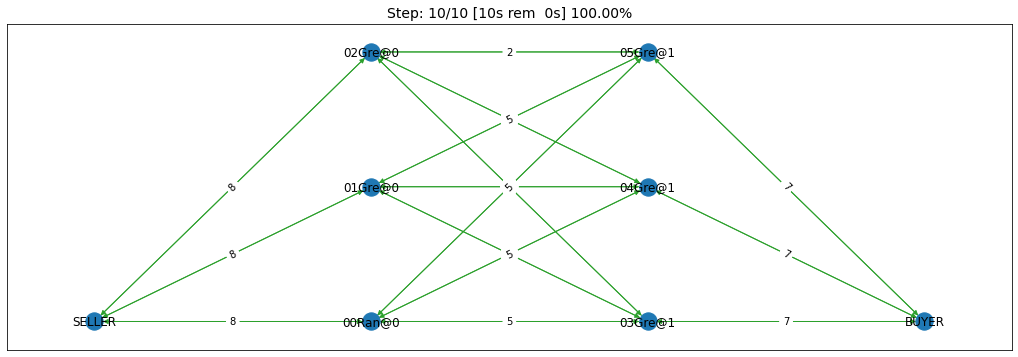

In [8]:
class GreedyOneShotAgent(OneShotAgent):
    """A greedy agent based on OneShotAgent"""
    
    def init(self):
        self.secured = 0
                
    def step(self):
        self.secured = 0
        
    def on_negotiation_success(self, contract, mechanism):
        self.secured += contract.agreement["quantity"]    

    def propose(self, negotiator_id: str, state) -> "Outcome":
        return self.best_offer(negotiator_id)

    def respond(self, negotiator_id, state, offer):
        my_needs = self._needed(negotiator_id)
        if my_needs <= 0:
            return ResponseType.END_NEGOTIATION
        return (
            ResponseType.ACCEPT_OFFER
            if offer[QUANTITY] <= my_needs
            else ResponseType.REJECT_OFFER
        )
    
    def best_offer(self, negotiator_id):
        my_needs = self._needed(negotiator_id)
        if my_needs <= 0:
            return None
        ami = self.get_ami(negotiator_id)
        if not ami:
            return None
        quantity_issue = ami.issues[QUANTITY]
        unit_price_issue = ami.issues[UNIT_PRICE]
        offer = [-1] * 3
        offer[QUANTITY] = max(
            min(my_needs, quantity_issue.max_value),
            quantity_issue.min_value
        )
        offer[TIME] = self.awi.current_step
        if self._is_selling(ami):
            offer[UNIT_PRICE] = unit_price_issue.max_value
        else:
            offer[UNIT_PRICE] = unit_price_issue.min_value        
        return tuple(offer)

    def _needed(self, negotiator_id=None):
        return self.awi.current_exogenous_input_quantity + \
               self.awi.current_exogenous_output_quantity - \
               self.secured
    
    def _is_selling(self, ami):
        return ami.annotation["product"] == self.awi.my_output_product
    
world, ascores, tscores = try_agent(GreedyOneShotAgent)

Let's see how well did this agent behave:

In [9]:
print_type_scores(tscores)

[('GreedyOneShotAgent', 0.9721971302299277), ('RandomOneShotAgent', 0.841121622141797)]


This simple agent is definitely better than the random agent. Let's understand how it works:

The main idea of this agent is pretty simple. It tries to *secure* as much of its needs (sales/supplies) as possible in every negotiation at the best possible price for itself.

To achieve this goal, the agent keeps track of the quantity it secured in its `init`, `step` and `on_negotiation_success` callbacks.

```python
def init(self):
    self.secured = 0

def step(self):
    self.secured = 0

def on_negotiation_success(self, contract, mechanism):
    self.secured += contract.agreement["quantity"]

```

Moreover, it defines a helper that calculates the amount it needs by subtracting the exogenous quantity it has from the amount it secured:

```python
def _needed(self):
    return self.awi.current_exogenous_input_quantity + \
           self.awi.current_exogenous_output_quantity - \
           self.secured
```

Notice that either the exogenous input quantity or the exogenous output quantity (or both) will always be zero. Now that the agent can calculate how much it needs to buy/sell, it implements the negotiation related call-backs (`propose` and `respond`). 

Here is the full implementation of `propose`:
```python
def propose(self, negotiator_id: str, state) -> "Outcome":
        return self.best_offer(negotiator_id)
```

The agent is always offering its best offer which is calculated in the `best_offer` method to be discussed later. It does not conceed at all.

Responding to opponent offers is also simple:

- it starts by calculating its needs using the helper `needed`, and ends the negotiation if it needs no more sales/supplies
```python
    my_needs = self._needed()
    if my_needs <= 0:
        return ResponseType.END_NEGOTIATION
```
- It then gets access to the `SAOAMI` (Stacked Alternating Offers Agent Mechanism Interface) object connecting the agent to this specific negotiation. Here we use the fact that the partner ID and the negotiator ID are always the same.
```python
    ami = self.get_ami(negotiator_id)
```
- If this is the last step, and the quantity offered is less than the agent's needs it accepts it, otherwise, it rejects the offer.
```python
    if state.step == ami.n_steps - 1:
        return (
            ResponseType.ACCEPT_OFFER
            if offer[QUANTITY] <= my_needs
            else ResponseType.REJECT_OFFER
        )
    return ResponseType.REJECT_OFFER
```

Most of the code is in the `best_offer` method which calculates the best offer for a negotiation *given the agreements reached so far*. Let's check it line by line:

- The agent checks its needs and returns `None` ending the negotiation if it needs no more sales/supplies. We also get access to the AMI.
```python
    my_needs = self._needed()
    if my_needs <= 0:
        return None
    ami = self.get_ami(negotiator_id)
```

- It then finds out the `Issue` objects corresponding to the quantity and unit-price for this negotiation and initializes an offer (we have 3 issues)
```python
    quantity_issue = ami.issues[QUANTITY]
    unit_price_issue = ami.issues[UNIT_PRICE]
    offer = [-1] * 3
```
- The time is always the current step. 
```python    
    offer[TIME] = self.awi.current_step
```
- The quantity to offer is simply the needs of the agent without mapped within the range of the quantities in the negotiation agenda (note that this may lead the agent to buy more than its needs). 
```python    
    offer[QUANTITY] = max(
        min(my_needs, quantity_issue.max_value), quantity_issue.min_value
    )
```
- Finally, the unit price is the maximum possible unit price if the agent is selling otherwise it is the minimum possible price. Note that `is_selling()` assumes that the agent will never find itself in a middle layer in a deep negotiation. We will alleviate this issue later. 
```python
    if self.is_selling():
        offer[UNIT_PRICE] = unit_price_issue.max_value
    else:
        offer[UNIT_PRICE] = unit_price_issue.min_value
    return tuple(offer)
```
That is it.

#### More General Greedy Agent

One issue that the `GreedyOneShotAget` had was that it assumed that it is either in the first level of the production chain or in the last level. To make an agent that works anywhere, we need just minor modifications:

In [10]:
class DeepGreedyAgent(GreedyOneShotAgent):
    """A greedy agent based on OneShotSyncAgent that does something 
    when in the middle of the production chain"""
    
    def init(self):
        self._sales = self._supplies = 0
                
    def step(self):
        self._sales = self._supplies = 0
        
    def on_negotiation_success(self, contract, mechanism):
        if contract.annotation["product"] == self.awi.my_input_product:
            self._sales += contract.agreement["quantity"]
        else:
            self._supplies += contract.agreement["quantity"]
        
    def _needed(self, negotiator_id):
        summary = self.awi.exogenous_contract_summary
        secured = ( 
            self._sales 
            if self._is_selling(self.get_ami(negotiator_id)) 
            else self._supplies
        )
        demand = min(summary[0][0], summary[-1][0]) / self.awi.n_competitors     
        return  demand - secured

Firstly, we now keep track of our sales and supplies separately:

```python
def init(self):
        self._sales = self._supplies = 0
                
def step(self):
    self._sales = self._supplies = 0

def on_negotiation_success(self, contract, mechanism):
    if contract.annotation["seller"] == self.id:
        self._sales += contract.agreement["quantity"]
    else:
        self._supplies += contract.agreement["quantity"]
```

To find out whether a contract is for sales or supplies, we simply check that the `seller` in the contract annotation is us. 

We need now two more changes:

- Modify the way we know whether a contract is for sales or supplies. This is done by comparing the `seller` attribute of the annotation associated with the negotiator to our ID.

```python
def _is_selling(self, negotiator_id):
    return self.negotiators[negotiator_id][0].ami.annotation["seller"] == self.id
```

- The final modification, is to separate the calculation of our needs for supplies and sales:
```python
def _needed(self, negotiator_id):
    summary = self.awi.exogenous_contract_summary
    q = min(summary[0][0], summary[-1][0])
    secured = self._sales if self._is_selling(negotiator_id) else self._supplies
    n_competitors = len(self.awi.all_consumers[self.awi.my_input_product]
    return int(q / n_competitors - secured)
```
 here we start by reading the summary information of exogenous contracts into `summary`. This is a list of two valued tuples giving the **total** quantity and **total** price (in that order) of all current exogenous contracts for all products. We also find the amount we secured (depending on whether this is a buy or a sell negotiation) and the number of competitors (i.e. agents in the same production level as us). We assume that we need to buy (and sell) the same quantity as the minimum of the raw material and final product exogenous contracts divided equally between us and our competitors.

Now, let's see how does this agent behave compared with the previous agent in a deep world simulation


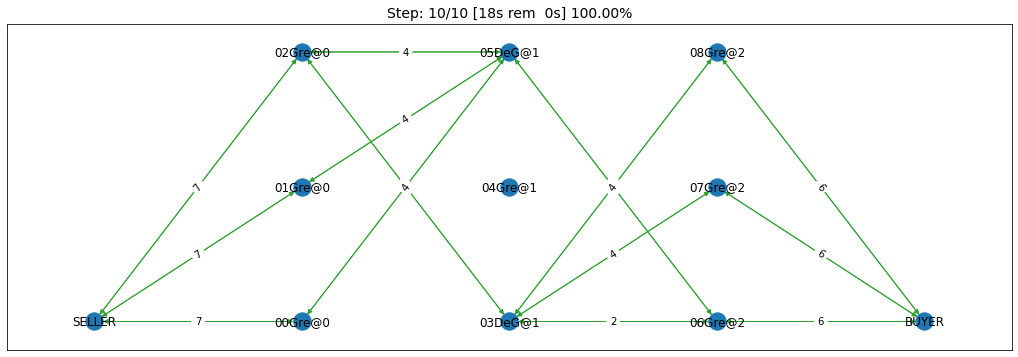

In [11]:
world, ascores, tscores = try_agents([GreedyOneShotAgent, DeepGreedyAgent], n_processes=3)

Examining the graph above, you can see that `DeepGreedy` agents could get contracts when they were in the middle of the production chain. The `GreedyOneShot` agent on the other hand failed to do so. 

Agents in the package `scml.oneshot.agents` were designed to work in deep production graphs not only in the first and last layer whenever that is possible.

We can check the results now:

In [12]:
print_type_scores(tscores)

[('GreedyOneShotAgent', 0.8409797601448952), ('DeepGreedyAgent', 0.7958920122224411)]


Even though our new `DeepGreedyAgent` was able to get contracts which in the middle, it seems that it did worse than `GreedyOneShotAgent` in terms of final profits. This may be just a quirk of this specific configuration. We will leave it to the reader to investigate this issue (if they choose to).

Given that the utility function of the agent is defined in terms of a *complete set of contracts*, it is not trivial to define a utility function for each negotiation independent from the others (which is why this is an inherently concurrent negotiation world). It may be easier then to think of all negotiations in a synchronized manner. This means that the agent keeps collecting offers from its partners and when it has a *complete set*, it responds to all of them. Moreover, to start negotiations in which the agent finds itself the first propsoer, it needs to define a first proposal for each negotiation. This is why `SyncOneShotAgent` allows you to do. 

<div class="alert alert-block alert-success">
You can now start developing your own agent for SCML-OneShot (A startup skeleton project is available <a href=http://www.yasserm.com/scml/scml.zip>here</a>). The rest of this tutorial will introduce two other <strong>optional</strong> alternatives</div>


### SyncOneShotAgent

The main goal of this base agent is to allow the developer to think about *all negotiations together* but it has some important caveats which we will discuss later.
Here is an example of writing the do-nothing agent in this form:

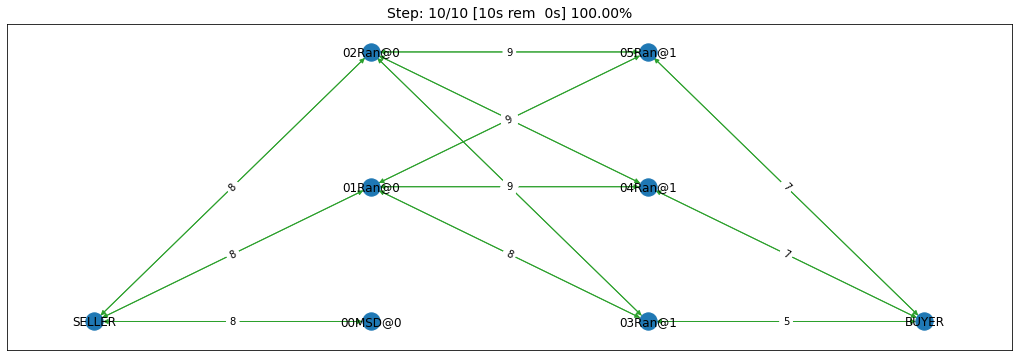

In [13]:
from negmas import SAOResponse
class MySyncOneShotDoNothing(OneShotSyncAgent):
    """My Agent that does nothing"""
    def counter_all(self, offers, states):
        """Respond to a set of offers given the negotiation state of each."""
        return dict(zip(self.negotiators.keys(), 
                        [SAOResponse(ResponseType.END_NEGOTIATION, None)] 
                        * len(self.negotiators)
                       ))
    
    def first_proposals(self):
        """Decide a first proposal on every negotiation. 
        Returning None for a negotiation means ending it."""
        return dict(zip(self.negotiators.keys(), 
                        [None] * len(self.negotiators)
                       ))
    
world, ascores, tscores = try_agent(MySyncOneShotDoNothing)

As you can see, in this case, we need to override `counter_all` to counter offers received from *all* the partners and `first_proposals` to decide a first offer for *each* partner. Notice that this is a many-to-many negotiation scenario. This means that if multiple agents at every level are using sync variants, loops may happen with the possiblity of a deadlock. 

For that reason the system will randomly break such loops when they happen which implies that **`counter_all` may receive a subset of the offers from partners not all of them**. In the worst case, `counter_all` may receive just one offer each time from one of the partners losing all synchronity between responses.

Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `step` call after each step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these six callbacks. All of these callbacks except `counter_all` and `first_proposals` are optional.

#### GreedySyncAgent

The main advantage of using the `OneShotSyncAgent` is that you do not need to keep track of state variables (like `secured`, `_supplies` and `_sales` used earlier) and you have a common place to make your decisions about **all** negotiations at the same time. Here is a simple greedy agent using this approach.

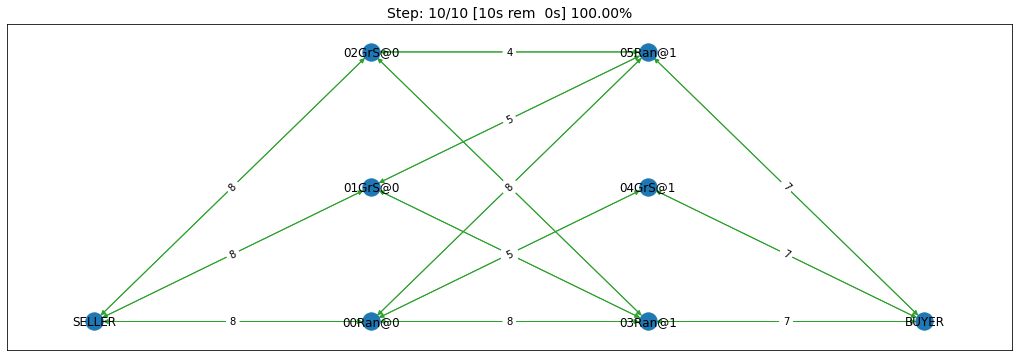

In [14]:
class GreedySyncAgent(OneShotSyncAgent, GreedyOneShotAgent):
    """A greedy agent based on OneShotSyncAgent"""
    
    def __init__(self, *args, threshold=0.3, **kwargs):
        super().__init__(*args, **kwargs)
        self._threshold = threshold
    
    def first_proposals(self):
        """Decide a first proposal on every negotiation. 
        Returning None for a negotiation means ending it."""
        return dict(zip(
                self.negotiators.keys(), 
                (self.best_offer(_) for _ in self.negotiators.keys())
        ))
    
    def counter_all(self, offers, states):
        """Respond to a set of offers given the negotiation state of each."""
        responses = {
            k: SAOResponse(ResponseType.REJECT_OFFER, _) 
            for k, v in self.first_proposals().items()
        }
        my_needs = self._needed()
        is_selling = ( self._is_selling(self.get_ami(_)) for _ in offers.keys() )
        sorted_offers = sorted(
            zip(offers.values(), is_selling), 
            key=lambda x: (- x[0][UNIT_PRICE]) if x[1] else x[0][UNIT_PRICE]
        )
        secured, outputs, chosen = 0, [], dict()
        for i, k in enumerate(offers.keys()):
            offer, is_output = sorted_offers[i]
            secured += offer[QUANTITY]
            if secured >= my_needs:
                break
            chosen[k] = offer
            outputs.append(is_output)
            
        u = self.ufun.from_offers(list(chosen.values()), outputs)
        rng = self.ufun.max_utility - self.ufun.min_utility
        threshold = self._threshold * rng + self.ufun.min_utility
        if u >= threshold:
            for k, v in chosen.items():
                responses[k] = SAOResponse(ResponseType.ACCEPT_OFFER, None)
        return responses
    
world, ascores, tscores = try_agent(GreedySyncAgent)

We need to implement two methods: `first_proposals` (to generate a good first proposal for each negotiation) and `counter_all` (for countering a set of offers). We inherit from `GreedyOneShotAgent` in order to get access to `best_offer` and `_is_selling` methods (we could have repeated them here again of course. Note that, because of the way inheritence works in python, we must inherit from `OneShotSyncAgent` before `GreedyOneShotAgent`.

The first set of proposals in `first_proposals` is simply the `best_offer` for each negotiation which is calculated using this generator expression:
```python
(self.best_offer(_) for _ in self.negotiators.keys())
```

Almost all the code now resides in the `counter_all` method. We will go over it here:

- We start by initializing our response by the best offer for each negotiation using `first_proposals` and calculating our needs using `_needed`
```python
responses = self.first_proposals()
outputs = list()
my_needs = self._needed(None)
```

- We then sort the offers so that earlier offers have *better* prices for us. For sell offers, this means descendingly and for buy offers ascendingly.
```python
sorted_offers = sorted(
    zip(offers.values(), (self._is_selling(_) for _ in offers.keys())), 
    key=lambda o, nid: - o[UNIT_PRICE] if self._selling(o) else o[UNIT_PRICE]
)
```
- We *greedily* find a set of offers that satisfy all our needs (or as much as possible from them). 
```python
secured, chosen = 0, dict()
for i, k in enumerate(offers.keys()):
    offer, is_output = sorted_offers[i]
    secured += offer[QUANTITY]
    if secured >= my_needs:
        break
    chosen[k], outputs[k] = offer, is_output
```
- Finally, we calculate the utility of accepting these *and only these* offers and accept the chosen offers if they provide 70% of the maximum possible utility. Otherwise, we reject all offers sending the default `best_offer` value back.
```python
u = self.ufun.from_offers(offers, outputs)
if u > 0.7 * self.ufun.max_utility:
    for k, v in chosen.items():
        responses[k] = SAOResponse(ResponseType.ACCEPT_OFFER, None)
```

Let's see how did it do:

In [15]:
print_type_scores(tscores)

[('GreedySyncAgent', 1.0512363920967527), ('RandomOneShotAgent', 0.8292152152905562)]


This base-class simplifies the job of the agent developer by providing a single function (`counter_all`) in which to handle all offers it receive (most of the time, remember that sometimes you will receive a subset of the offers in the call). In principle the agent can then decide to accept a few of these offers and keep negotiating. 

In many cases, it may be possible to secure all of the agent's needs (i.e. supplies or sales) using a **single** contract with one of its partners. In such cases, the agent can think about the negotiations it is engaged in as a **competetive negotiation** not very dissimilar from an auction that also allows it to offer. This can lead to a further simplification, the agent can be designed to get **at most one agreement** from the set of negotiation and end all the rest once this is achieved. This is what the `SingleAgreementOneShotAgent` does.

### SingleAgreementOneShotAgent
This base classs allows you to develop agents that can get **at most** one agreement from the set of negotiation at every simulation step. 

This controller manages a set of negotiations from which only a single one
-- at most -- is likely to result in an agreement. To guarentee a single agreement, pass ```strict=True```.

The general algorithm for this controller is something like this:

- Receive offers from all partners.
- Find the best offer among them by calling the abstract `best_offer`
  method.
- Check if this best offer is acceptable using the abstract `is_acceptable`
  method.

    - If the best offer is acceptable, accept it and end all other negotiations.
    - If the best offer is still not acceptable, then all offers are rejected
      and with the partner who sent it receiving the result of `best_outcome`
      while the rest of the partners receive the result of `make_outcome`.

- The default behavior of `best_outcome` is to return the outcome with
  maximum utility.
- The default behavior of `make_outcome` is to return the best offer
  received in this round if it is valid for the respective negotiation
  and the result of `best_outcome` otherwise.
  
To use this agent, you need to implement three methods:

- `is_acceptable` decides whether an offer is now acceptable. For this simple agent, we accept an offer if it provides us with at least 70% of the maximum possible utility.
```python
return self.ufun(offer) > 0.7 * self.ufun.max_utility
```
- `best_offer` finds the best offer among a set of offers. Here we simply compare their utility
```python
ufuns = [(self.ufun(_), i) for i, _ in enumerate(offers.values())]
keys = list(offers.keys())
return keys[max(ufuns)[1]]
```
- `is_better` which compares two offers from the same negotiator. We simply compare their utility value:
```python
return self.ufun(a) > self.ufun(b)
```

Here is the full agent

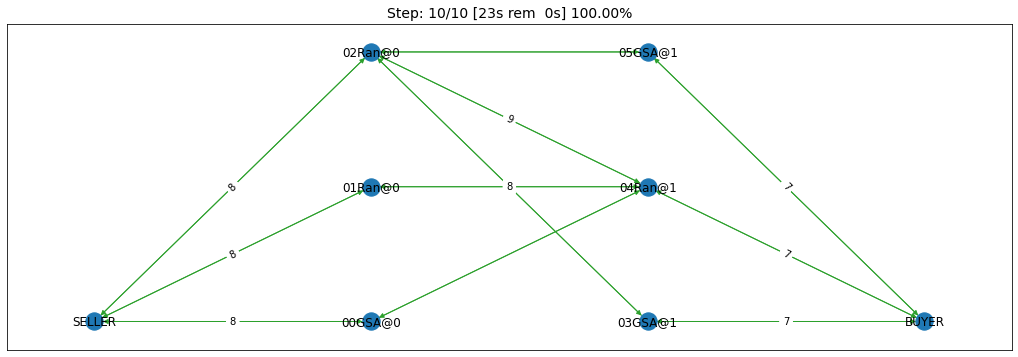

In [16]:
class GreedySingleAgreementAgent(OneShotSingleAgreementAgent):
    """A greedy agent based on OneShotSingleAgreementAgent"""   
    
    def is_acceptable(self, offer, source, state) -> bool:        
        mx, mn = self.ufun.max_utility , self.ufun.min_utility
        u = (self.ufun(offer) - mn) / (mx - mn) 
        return  u >= (1-state.relative_time)

    def best_offer(self, offers):
        ufuns = [(self.ufun(_), i) 
                 for i, _ in enumerate(offers.values())]
        keys = list(offers.keys())
        return keys[max(ufuns)[1]]

    def is_better(self, a, b, negotiator, state):
        return self.ufun(a) > self.ufun(b)

world, ascors, tscores = try_agent(GreedySingleAgreementAgent)

In [17]:
print_type_scores(tscores)

[('GreedySingleAgreementAgent', 0.9271810643670331), ('RandomOneShotAgent', 0.7817845346479539)]


### Comparing all agents

Let's run a tournament comparing all agents we developed in this tutorial (we will ignore the do-nothing agents)

In [18]:
# may take a long time
_, _, tscores = try_agents(
    [GreedyOneShotAgent, GreedySingleAgreementAgent, GreedySyncAgent], 
    n_trials=20, 
    n_processes=2,
    draw=False
)
print_type_scores(tscores)

[('GreedySyncAgent', 0.9225122922462091), ('GreedyOneShotAgent', 0.8928263129600016), ('GreedySingleAgreementAgent', 0.7937408045096188)]


The way we just compared these agents is not unbiased because not all agents are allowed to control the same factories in the same simulation envoironment. The best way to compare these agents is to run a tournament between them. You already learned how to do that in the previous tutorial and we will not repeate it here.

*If you are running this notebook, please note that the tournament running methods `anac2021_*` may not work within a notebook environment. You can just move your code to a normal python script and it will run correctly*


You can find all the agents available in the `scml` package for the one-shot game under `scml.oneshot.agents` including the ones developed in this tutorial:

In [19]:
import scml.oneshot.agents as agents
print([ _ for _ in agents.__dir__() if _.endswith("Agent")])

['RandomOneShotAgent', 'SyncRandomOneShotAgent', 'SingleAgreementRandomAgent', 'SingleAgreementAspirationAgent', 'GreedyOneShotAgent', 'GreedySyncAgent', 'GreedySingleAgreementAgent', 'OneshotDoNothingAgent']


### Running SCML2020 agents (advanced)

The SCML-OneShot game is much simpler than the full SCML2020 game used in the ANAC 2020 SCML league or the ANAC 2021 SCML standard and collusion tracks. Nevertheless, we provide an out-of-the-box adapter allowing agents developed for the full competition to run in the on-shot track (with some rough edges). Let's try to do that here:

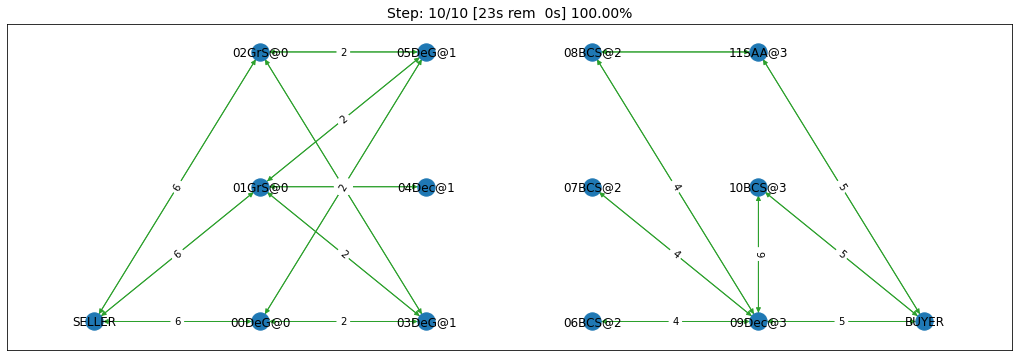

In [20]:
from scml.scml2020.agents import BuyCheapSellExpensiveAgent, DecentralizingAgent
from scml.oneshot.agents import SingleAgreementAspirationAgent
_, _, tscores = try_agents(
[DeepGreedyAgent, GreedySyncAgent, SingleAgreementAspirationAgent, BuyCheapSellExpensiveAgent, DecentralizingAgent],
n_processes = 4,
n_trials = 10,
)

In [21]:
print_type_scores(tscores)

[('GreedySyncAgent', 0.961265912882057), ('BuyCheapSellExpensiveAgent', 0.9310856952666312), ('SingleAgreementAspirationAgent', 0.8968162775246209), ('DeepGreedyAgent', 0.8539231856326932), ('DecentralizingAgent', 0.580214277114553)]


For an SCML agent participating in the OneShot game, the main issues to take into account are the following:

1. The system will **override** the agenda the agent proposes in negotiation requests with the same agenda it always uses for the one-shot game. More specifically, the time will be the current step for buying negotiation requests and the next step for selling negotiation requests. Quantities and unit prices will also be adjusted as explaind in the [OneShot game description](http://www.yasserm.com/scml/scml2021oneshot.pdf).
2. The agent will not be able to do any trade about any steps beyond the next step. 

With that we end our tutorial. Have fun developing your agent.